## Lista de series temporais


1 – A base trabalhadores.xlsx mostra a quantidade de trabalhadores (em mil) de uma certa indústria, ao longo de 5 anos com variações mensais. Ajuste um modelo prophet para esses dados, prevendo os próximos 18 meses.

Importing plotly failed. Interactive plots will not work.
10:07:31 - cmdstanpy - INFO - Chain [1] start processing
10:07:31 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\gugat\AppData\Local\Temp\ipykernel_24096\2521052726.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


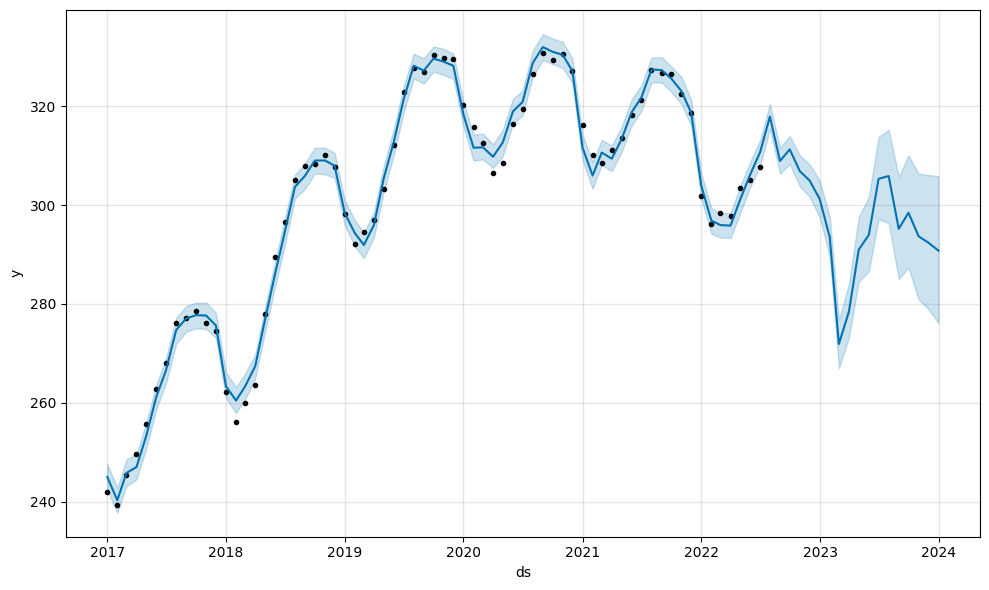

In [1]:
import pandas as pd
from prophet import Prophet


trabalhadores_df = pd.read_excel("trabalhadores.xlsx")
trabalhadores_df.rename(columns={'Data': 'ds', 'trabalhadores': 'y'}, inplace=True)

prophet_model = Prophet(yearly_seasonality=True)
prophet_model.fit(trabalhadores_df)

# Prever os próximos 18 meses
future = prophet_model.make_future_dataframe(periods=18, freq='M')
forecast = prophet_model.predict(future)

fig = prophet_model.plot(forecast)
fig.show()

2 - A base clientes.xlsx é uma base que mostra a evolução no número de clientes de uma certa indústria ao longo de um período de 144 meses (12 anos). Ajuste um modelo prophet para esses dados, prevendo os próximos 24 meses.

10:07:32 - cmdstanpy - INFO - Chain [1] start processing
10:07:32 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\gugat\AppData\Local\Temp\ipykernel_24096\3050971701.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_clientes.show()


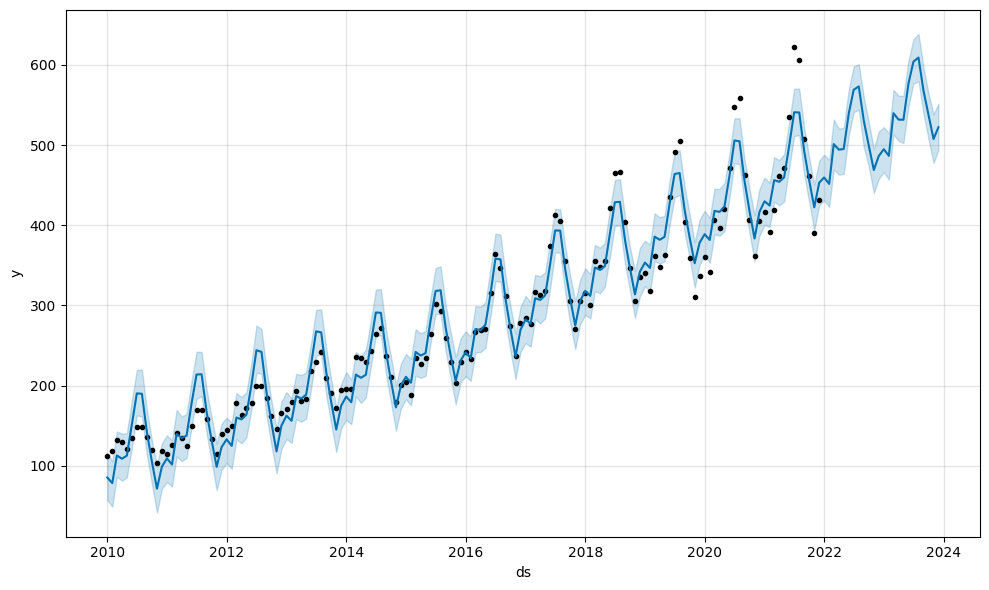

In [2]:
clientes_df = pd.read_excel("Clientes.xlsx")
clientes_df.rename(columns={'Data': 'ds', 'Clientes': 'y'}, inplace=True)

prophet_model_clientes = Prophet(yearly_seasonality=True)
prophet_model_clientes.fit(clientes_df)

# Prever os próximos 24 meses
future_clientes = prophet_model_clientes.make_future_dataframe(periods=24, freq='M')
forecast_clientes = prophet_model_clientes.predict(future_clientes)

fig_clientes = prophet_model_clientes.plot(forecast_clientes)
fig_clientes.show()

3- A base Duráveis_veic.xlsx mostra as vendas de bens duráveis e veículos no mercado americano num período de 21 anos. Construa um modelo VAR para cada produto investigando se um produto afeta na venda do outro. Faça a previsão dos próximos 12 meses

In [3]:
from statsmodels.tsa.stattools import adfuller


duraveis_veic_df = pd.read_excel("Duraveis_veic.xlsx")
duraveis_veic_df.set_index('Data', inplace=True)
duraveis_veic_df

,bens_duraveis,Veiculos
Data,,
2001-01-01,26617,4367
2001-02-01,29829,5147
2001-03-01,31336,5418
2001-04-01,30484,4897
2001-05-01,31008,5002
...,...,...
2021-08-01,122340,19311
2021-09-01,133506,20827
2021-10-01,130927,23388


In [4]:
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    conclusion = 'Stationary' if result[1] <= 0.05 else 'Non-Stationary'
    return title, conclusion, result[1]


duraveis_result = adf_test(duraveis_veic_df['bens_duraveis'], 'bens_duraveis')
veiculos_result = adf_test(duraveis_veic_df['Veiculos'], 'Veiculos')

duraveis_result, veiculos_result

(('bens_duraveis', 'Non-Stationary', 0.7587283723101297),
 ('Veiculos', 'Non-Stationary', 0.8857718563518948))

**Hipótese nula (H0)**: A série temporal possui uma raiz unitária (não estacionária).
**Hipótese alternativa (H1)**: A série temporal não possui uma raiz unitária (estacionária).
Um valor-p menor do que um determinado nível de significância (geralmente 0,05), rejeitamos a hipótese nula e concluímos que a série é estacionária

**Diferenciação**
A diferença entre observações consecutivas é calculada. Isso é frequentemente eficaz para eliminar tendências ou ciclos sazonais.

- **Primeira diferenciação**:
  $$\[ Y'_t = Y_t - Y_{t-1} \]$$

- **Segunda diferenciação**:
  $$\[ Y''_t = Y'_t - Y'_{t-1} \]$$

E assim por diante, até que a série se torne estacionária.


In [5]:
# Differentiate the series
duraveis_veic_df['bens_duraveis_diff'] = duraveis_veic_df['bens_duraveis'].diff().dropna()
duraveis_veic_df['Veiculos_diff'] = duraveis_veic_df['Veiculos'].diff().dropna()

# Test stationarity for differentiated series
duraveis_diff_result = adf_test(duraveis_veic_df['bens_duraveis_diff'].dropna(), 'bens_duraveis_diff')
veiculos_diff_result = adf_test(duraveis_veic_df['Veiculos_diff'].dropna(), 'Veiculos_diff')

duraveis_diff_result, veiculos_diff_result

(('bens_duraveis_diff', 'Stationary', 0.0027002802527589936),
 ('Veiculos_diff', 'Stationary', 0.0005678813344086949))

In [6]:
from statsmodels.tsa.api import VAR

duraveis_veic_df.dropna(inplace=True)

train = duraveis_veic_df[:-12][['bens_duraveis_diff', 'Veiculos_diff']]
test = duraveis_veic_df[-12:][['bens_duraveis_diff', 'Veiculos_diff']]

# Fit the VAR model
var_model = VAR(train)
var_result = var_model.fit(maxlags=12, ic='aic')

# Forecasting for next 12 months
forecast = var_result.forecast(train.values, steps=12)

forecast_df = pd.DataFrame(forecast, columns=['bens_duraveis_diff', 'Veiculos_diff'])
forecast_df

C:\Users\gugat\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


,bens_duraveis_diff,Veiculos_diff
0,-17389.525639,-1296.924190
1,19455.116277,7126.713861
2,9957.022177,833.679902
3,-13904.262445,-1269.206503
4,5718.354815,2408.245307
5,10551.848226,700.211103
6,-27542.652045,-8014.757883
7,16033.186803,5979.487123
8,11547.329878,888.703312
9,-3361.957915,2152.791182


In [7]:
# Reverte a diferenciação
forecast_df['bens_duraveis_forecast'] = duraveis_veic_df['bens_duraveis'].iloc[-13] + forecast_df['bens_duraveis_diff'].cumsum()
forecast_df['Veiculos_forecast'] = duraveis_veic_df['Veiculos'].iloc[-13] + forecast_df['Veiculos_diff'].cumsum()

# Extrai os valores reais
actual_bens_duraveis = duraveis_veic_df['bens_duraveis'].iloc[-12:].values
actual_Veiculos = duraveis_veic_df['Veiculos'].iloc[-12:].values

# Comparando os resultados
comparison_df = pd.DataFrame({
    'Month': duraveis_veic_df.index[-12:],
    'Actual_bens_duraveis': actual_bens_duraveis,
    'Forecasted_bens_duraveis': forecast_df['bens_duraveis_forecast'].values,
    'Actual_Veiculos': actual_Veiculos,
    'Forecasted_Veiculos': forecast_df['Veiculos_forecast'].values
})

comparison_df

,Month,Actual_bens_duraveis,Forecasted_bens_duraveis,Actual_Veiculos,Forecasted_Veiculos
0,2021-01-01,104622,102294.474361,15467,10487.075810
1,2021-02-01,116914,121749.590638,17002,17613.789670
2,2021-03-01,122049,131706.612816,15952,18447.469572
3,2021-04-01,120571,117802.350370,18767,17178.263069
4,2021-05-01,123418,123520.705185,20605,19586.508376
5,2021-06-01,133092,134072.553411,19809,20286.719478
6,2021-07-01,107332,106529.901365,14233,12271.961595
7,2021-08-01,122340,122563.088168,19311,18251.448718
8,2021-09-01,133506,134110.418046,20827,19140.152030
9,2021-10-01,130927,130748.460131,23388,21292.943212


In [8]:
# Calcule e exiba as estatísticas de avaliação do modelo
print("Estatísticas de Avaliação do Modelo:")
print("AIC (Critério de Informação Akaike):", var_result.aic)
print("BIC (Critério de Informação Bayesiano):", var_result.bic)

Estatísticas de Avaliação do Modelo:
AIC (Critério de Informação Akaike): 28.817224330683576
BIC (Critério de Informação Bayesiano): 29.57161860766186


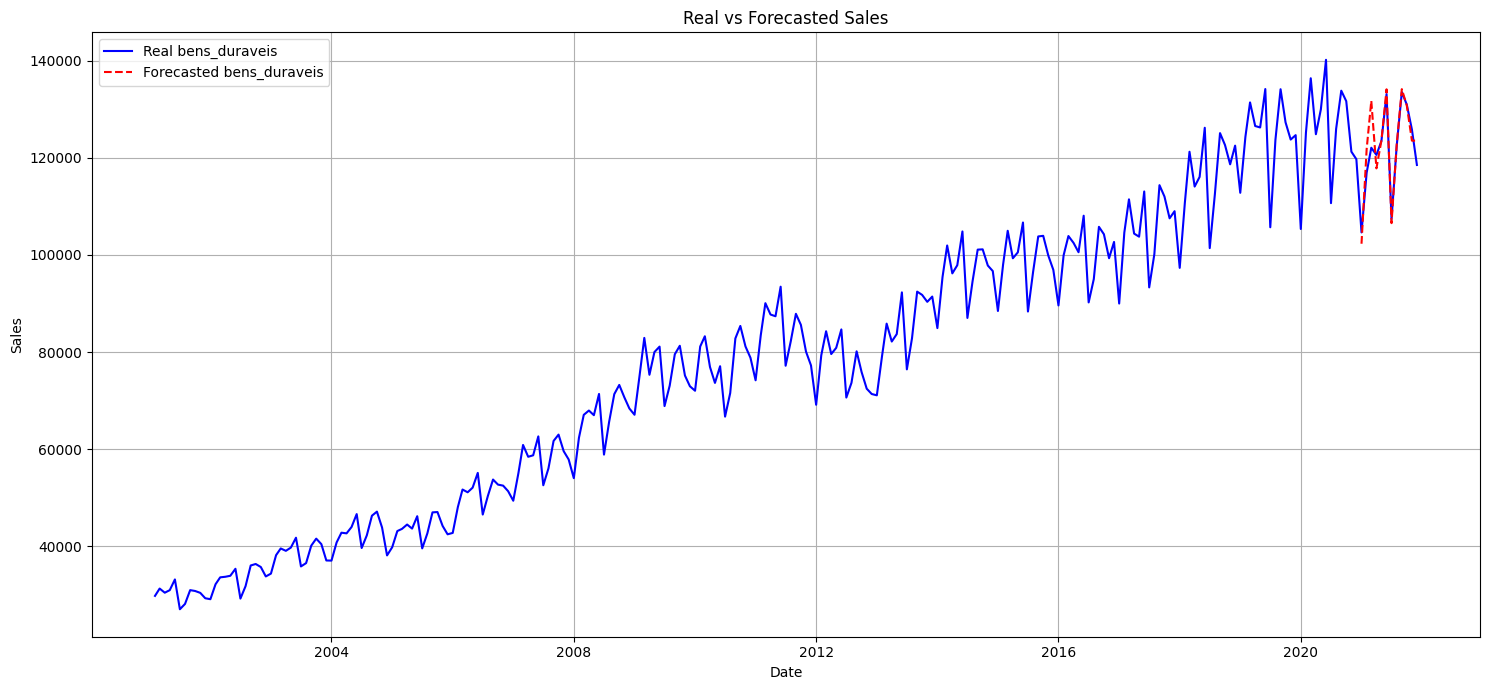

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(duraveis_veic_df.index, duraveis_veic_df['bens_duraveis'], label='Real bens_duraveis', color='blue')
plt.plot(duraveis_veic_df.index[-12:], forecast_df['bens_duraveis_forecast'].values, linestyle='--', label='Forecasted bens_duraveis', color='red')


plt.legend()
plt.title("Real vs Forecasted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

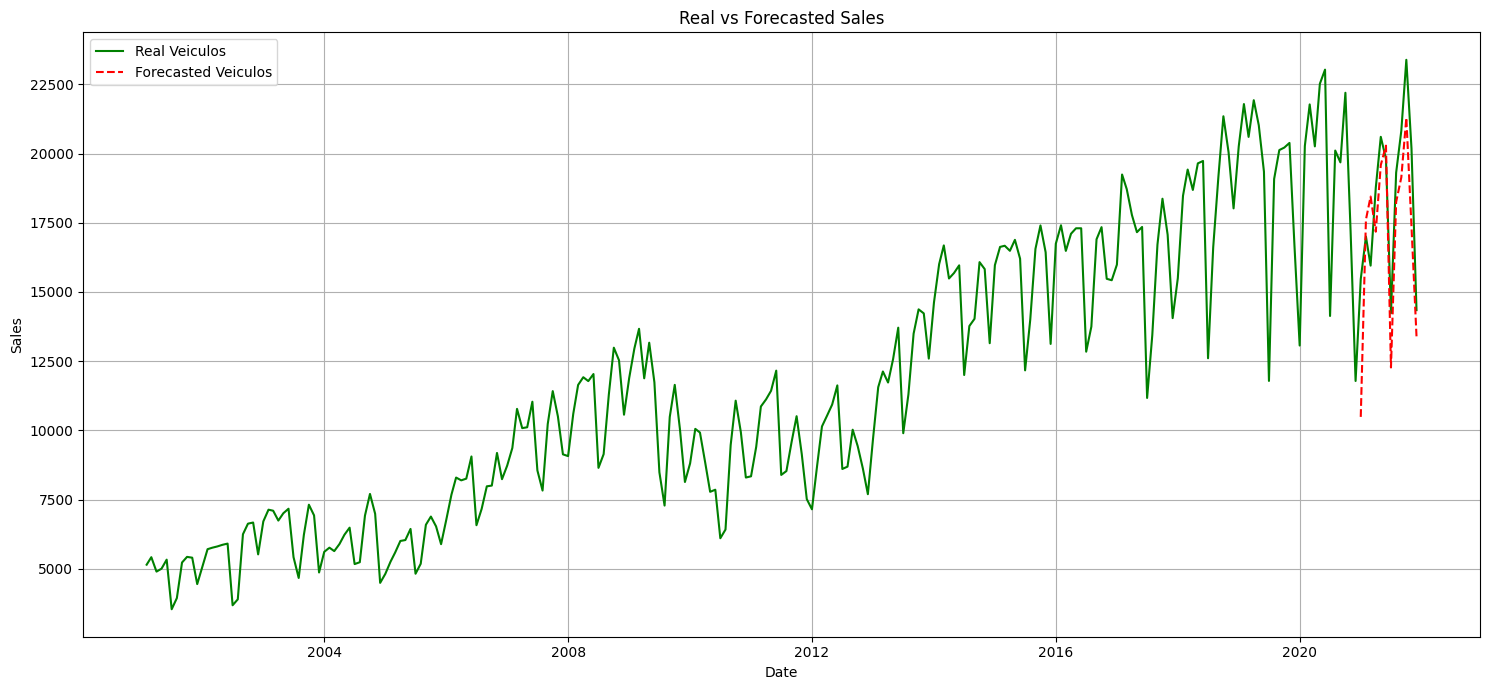

In [15]:
plt.figure(figsize=(15, 7))

plt.plot(duraveis_veic_df.index, duraveis_veic_df['Veiculos'], label='Real Veiculos', color='green')
plt.plot(duraveis_veic_df.index[-12:], forecast_df['Veiculos_forecast'].values, linestyle='--', label='Forecasted Veiculos', color='red')

plt.legend()
plt.title("Real vs Forecasted Sales")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

Agora que validamos o modelo vamos retreinar com todos os dados e prever para os proximos 12 meses

C:\Users\gugat\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


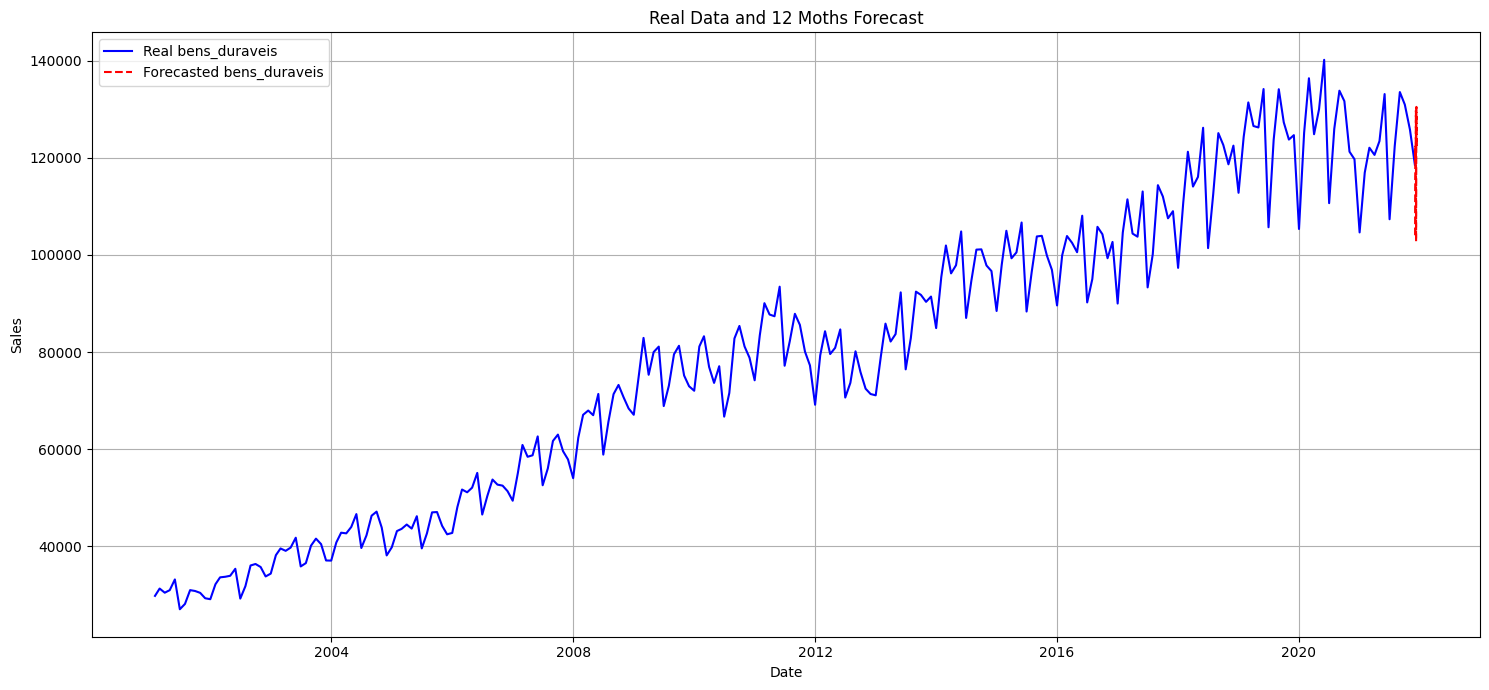

In [18]:
full_var_model = VAR(duraveis_veic_df[['bens_duraveis_diff', 'Veiculos_diff']])
full_var_result = full_var_model.fit(maxlags=12, ic='aic')

next_12_months_forecast = full_var_result.forecast(duraveis_veic_df[['bens_duraveis_diff', 'Veiculos_diff']].values, steps=12)

next_12_months_forecast_df = pd.DataFrame(next_12_months_forecast, columns=['bens_duraveis_diff', 'Veiculos_diff'])

next_12_months_forecast_df['bens_duraveis_forecast'] = duraveis_veic_df['bens_duraveis'].iloc[-1] + next_12_months_forecast_df['bens_duraveis_diff'].cumsum()
next_12_months_forecast_df['Veiculos_forecast'] = duraveis_veic_df['Veiculos'].iloc[-1] + next_12_months_forecast_df['Veiculos_diff'].cumsum()

forecast_index = pd.date_range(duraveis_veic_df.index[-1], periods=13, inclusive='right')

next_12_months_forecast_df.index = forecast_index

plt.figure(figsize=(15, 7))
plt.plot(duraveis_veic_df.index, duraveis_veic_df['bens_duraveis'], label='Real bens_duraveis', color='blue')
plt.plot(next_12_months_forecast_df.index, next_12_months_forecast_df['bens_duraveis_forecast'], linestyle='--', label='Forecasted bens_duraveis', color='red')


plt.legend()
plt.title("Real Data and 12 Moths Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()

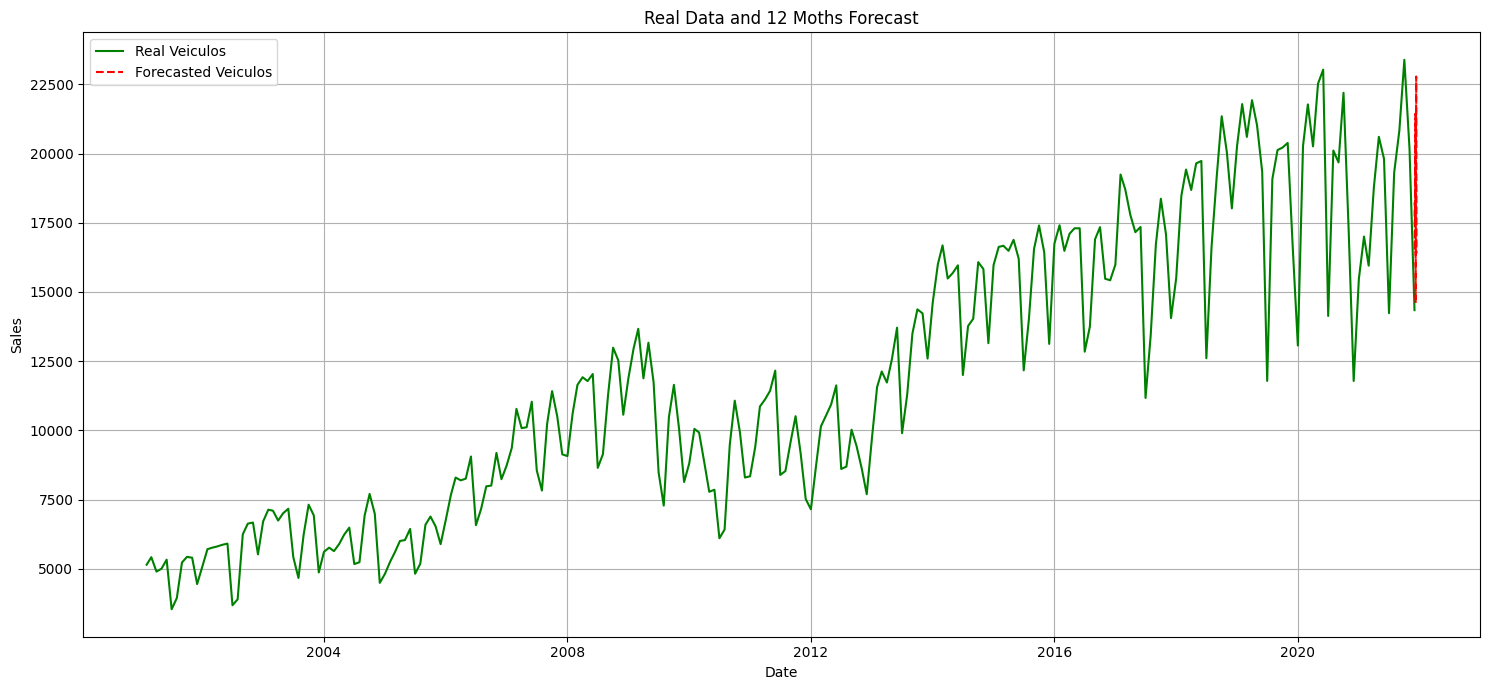

In [19]:
plt.figure(figsize=(15, 7))
plt.plot(duraveis_veic_df.index, duraveis_veic_df['Veiculos'], label='Real Veiculos', color='green')
plt.plot(next_12_months_forecast_df.index, next_12_months_forecast_df['Veiculos_forecast'], linestyle='--', label='Forecasted Veiculos', color='red')

plt.legend()
plt.title("Real Data and 12 Moths Forecast")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.grid(True)
plt.tight_layout()
plt.show()